In [67]:
import re
from datetime import datetime

In [68]:
import os
import geopandas as gpd
import geemap
import xml.etree.ElementTree as ET
import pandas as pd
from shapely.geometry import LineString

# constante requerida
namespace = {"kml": "http://www.opengis.net/kml/2.2"}

In [69]:
# Directorio donde están los archivos KML
path_kml = r'G:/OneDrive - Ingenio Azucarero Guabira S.A/UTEA_2023/PROYECTO AREA LIBERACION/LOGS/cierre_151223/'
contenido = os.listdir(path_kml)
len(contenido)

100

In [70]:
contenido

['Dec-12th-2023-11-01AM-Flight-Airdata.kml',
 'Dec-12th-2023-11-03AM-Flight-Airdata.kml',
 'Dec-12th-2023-12-49AM-Flight-Airdata.kml',
 'Dec-13th-2023-09-05PM-Flight-Airdata.kml',
 'Dec-13th-2023-09-22PM-Flight-Airdata.kml',
 'Dec-14th-2023-01-29AM-Flight-Airdata.kml',
 'Dec-14th-2023-03-27AM-Flight-Airdata.kml',
 'Dec-14th-2023-12-27AM-Flight-Airdata.kml',
 'Dec-1st-2023-04-02AM-Flight-Airdata.kml',
 'Dec-1st-2023-08-00AM-Flight-Airdata.kml',
 'Dec-1st-2023-08-22AM-Flight-Airdata.kml',
 'Dec-1st-2023-12-06AM-Flight-Airdata.kml',
 'Dec-4th-2023-03-25AM-Flight-Airdata.kml',
 'Dec-4th-2023-04-48AM-Flight-Airdata (1).kml',
 'Dec-4th-2023-04-48AM-Flight-Airdata.kml',
 'Dec-4th-2023-05-01AM-Flight-Airdata.kml',
 'Dec-4th-2023-05-09AM-Flight-Airdata.kml',
 'Dec-4th-2023-05-37AM-Flight-Airdata.kml',
 'Dec-4th-2023-06-09AM-Flight-Airdata.kml',
 'Dec-4th-2023-06-32AM-Flight-Airdata.kml',
 'Dec-4th-2023-06-47AM-Flight-Airdata.kml',
 'Dec-4th-2023-07-21AM-Flight-Airdata.kml',
 'Dec-4th-2023-07-30

In [71]:
def extraer_fecha(fecha_txt):
    match = re.search(r"([A-Za-z]{3}-\d{1,2}[a-z]{2}-\d{4})", fecha_txt)
    return match.group(1) if match else None

def format_date(date_str):
    try:
        # Eliminar sufijos ordinales para facilitar la conversión
        date_without_suffix = re.sub(r'(st|nd|rd|th)', '', date_str)
        return pd.to_datetime(date_without_suffix, format='%b-%d-%Y').strftime('%d/%m/%Y')
    except:
        return None

def week_number(date_str):
    """
    Retorna el número de semana del año para una fecha dada en formato "dd/mm/aaaa".
    """
    try:
        date_obj = pd.to_datetime(date_str, format='%d/%m/%Y')
        return date_obj.isocalendar()[1]  # El segundo valor de isocalendar() es el número de semana
    except:
        return None

In [72]:
# lista para almacenar nombres de archivo
file_name = []
# lista para alamcenar recorridos
lineas = []

# itera sobre la lista de nombres de archivos
for i in contenido:
    # directorio + nombre de archivo
    path = path_kml + i
    # leer el arbol de contenido del archivo
    tree = ET.parse(path)
    root = tree.getroot()
    for placemark in root.findall(".//kml:Placemark", namespace):
        coord_text = placemark.find(".//kml:coordinates", namespace).text.strip()
        # obtiene las cooredenadas
        coords = coord_text.split('\n')
        # lista para guardar las coors
        coordinates = []
        # recorre las coors
        for j in coords:
            # split para separa el 3er elemento que acompaña las coors
            coord = j.split(',')
            # agrega las coors a la lista
            coordinates.append((float(coord[0]), float(coord[1])))
    # conviente en DF
    df = pd.DataFrame(coordinates, columns=['Longitude', 'Latitude'])
    # convierte en GDF
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    # convierte el GDF en Linea
    line = LineString(gdf.geometry.tolist())
    # se almacena en listas el nombre del archivo y la geomedia del recorrido
    file_name.append(i)
    lineas.append(line)

In [73]:
fechas = [extraer_fecha(i) for i in file_name]

In [74]:
fechas = [format_date(i) for i in fechas]

In [75]:
semanas = [week_number(i) for i in fechas]

In [76]:
# dic con la geometria y el file_name
data_lineas = {
    'geometry': lineas,
    'nombre': file_name,
    'fecha' : fechas,
    'semana' : semanas
}

In [77]:
gdf_lineas = gpd.GeoDataFrame(data_lineas)

In [78]:
gdf_lineas.crs = "EPSG:4326"

In [79]:
gdf_lineas = gdf_lineas.to_crs(epsg=32720)

In [80]:
gdf_lineas

,geometry,nombre,fecha,semana
0,"LINESTRING (482289.229 8101086.244, 482289.227...",Dec-12th-2023-11-01AM-Flight-Airdata.kml,12/12/2023,50
1,"LINESTRING (482950.833 8101685.753, 482950.833...",Dec-12th-2023-11-03AM-Flight-Airdata.kml,12/12/2023,50
2,"LINESTRING (486174.249 8104638.277, 486174.244...",Dec-12th-2023-12-49AM-Flight-Airdata.kml,12/12/2023,50
3,"LINESTRING (477098.622 8097784.337, 477098.622...",Dec-13th-2023-09-05PM-Flight-Airdata.kml,13/12/2023,50
4,"LINESTRING (477099.831 8097787.632, 477099.836...",Dec-13th-2023-09-22PM-Flight-Airdata.kml,13/12/2023,50
...,...,...,...,...
95,"LINESTRING (499622.691 8090651.005, 499622.689...",Nov-30th-2023-01-24AM-Flight-Airdata.kml,30/11/2023,48
96,"LINESTRING (489495.868 8092764.319, 489495.869...",Nov-30th-2023-02-40AM-Flight-Airdata.kml,30/11/2023,48
97,"LINESTRING (489796.453 8092679.795, 489796.505...",Nov-30th-2023-03-10AM-Flight-Airdata.kml,30/11/2023,48
98,"LINESTRING (490137.413 8093094.250, 490137.419...",Nov-30th-2023-03-35AM-Flight-Airdata.kml,30/11/2023,48


<Axes: >

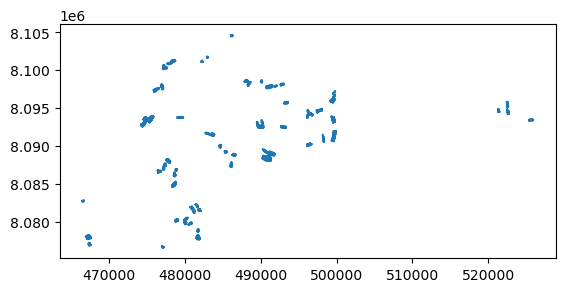

In [81]:
gdf_lineas.plot()

In [82]:
len(gdf_lineas)

100

In [83]:
gdf_lineas.to_file('capa_logs_6', driver="ESRI Shapefile")